### import packages

In [1]:
%matplotlib inline
import numpy as np
import torch
import copy
import pandas as pd
import SimpleITK as sitk
from PIL import Image
import pydicom
import cv2
import nibabel as nib
import os
import skimage.io as io

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from func.model_arch import SegAirwayModel
from func.model_run import get_image_and_label, get_crop_of_image_and_label_within_the_range_of_airway_foreground, \
semantic_segment_crop_and_cat, dice_accuracy
from func.post_process import post_process, add_broken_parts_to_the_result, find_end_point_of_the_airway_centerline, \
get_super_vox, Cluster_super_vox, delete_fragments, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, fill_inner_hole
from func.detect_tree import tree_detection
from func.ulti import save_obj, load_obj, get_and_save_3d_img_for_one_case,load_one_CT_img, \
get_df_of_centerline, get_df_of_line_of_centerline

### load data

[Option 1] get 3D image from DCM images

In [2]:
intput_img_path = "test_data/DCM_imgs" # these DCM images come from a dataset which was not used for training
raw_img_path = "results/raw_img.nii.gz"
get_and_save_3d_img_for_one_case(img_path = intput_img_path,
                                 output_file_path = raw_img_path) 

[Option 2] or you can directly load the 3D .nii.gz image if you already have it

In [5]:
raw_img_path = "test_data/test_image.nii.gz"

### load model

In [6]:
raw_img = load_one_CT_img(raw_img_path)

In [7]:
raw_img.shape

(536, 512, 512)

set the ```device``` to be used (CPU or GPU)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
model=SegAirwayModel(in_channels=1, out_channels=2)
model.to(device)
load_path = "checkpoint/checkpoint.pkl"
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
model_semi_supervise_learning=SegAirwayModel(in_channels=1, out_channels=2)
model_semi_supervise_learning.to(device)
load_path = "checkpoint/checkpoint_semi_supervise_learning.pkl"
checkpoint = torch.load(load_path)
model_semi_supervise_learning.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### run on 3D image

In [11]:
threshold = 0.5

In [12]:
seg_result_semi_supervise_learning = semantic_segment_crop_and_cat(raw_img, model_semi_supervise_learning, device,
                                                                   crop_cube_size=[32, 128, 128], stride=[16, 64, 64],
                                                                   windowMin=-1000, windowMax=600)
seg_onehot_semi_supervise_learning = np.array(seg_result_semi_supervise_learning>threshold, dtype=np.int)

KeyboardInterrupt: 

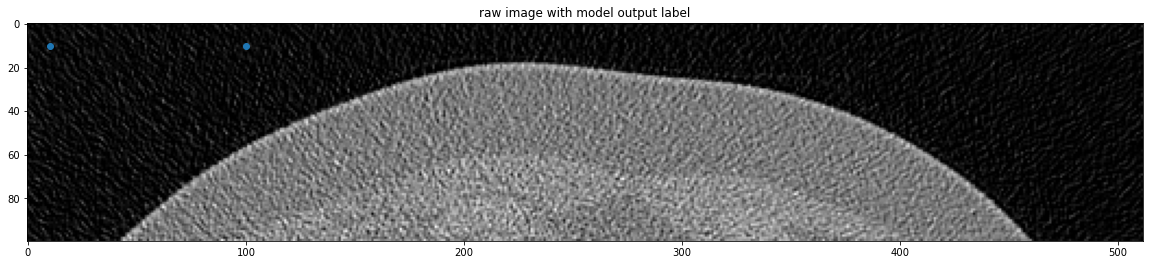

In [16]:
plt.figure(figsize=(20,20))
plt.title("raw image with model output label")
plt.imshow(raw_img[150,:,:], cmap='gray')
plt.scatter([10, 100], [10, 10])

In [11]:
# plt.figure(figsize=(20,20))
# plt.title("model output (top view)")
# plt.imshow(np.sum(seg_onehot_semi_supervise_learning, axis=1), cmap='gray')

In [12]:
seg_result = semantic_segment_crop_and_cat(raw_img, model, device,
                                           crop_cube_size=[32, 128, 128], stride=[16, 64, 64],
                                           windowMin=-1000, windowMax=600)
seg_onehot = np.array(seg_result>threshold, dtype=np.int)

C:\Users\sendo\AppData\Local\Temp\ipykernel_22540\586640011.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_onehot = np.array(seg_result>threshold, dtype=np.int)


In [13]:
# plt.figure(figsize=(20,20))
# plt.title("model output (top view)")
# plt.imshow(np.sum(seg_onehot, axis=1), cmap='gray')

In [14]:
seg_onehot_comb = np.array((seg_onehot+seg_onehot_semi_supervise_learning)>0, dtype=np.int)
seg_result_comb = (seg_result+seg_result_semi_supervise_learning)/2

C:\Users\sendo\AppData\Local\Temp\ipykernel_22540\4268311362.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_onehot_comb = np.array((seg_onehot+seg_onehot_semi_supervise_learning)>0, dtype=np.int)


In [ ]:
raw_img_path = "results/raw_img.nii.gz"
get_and_save_3d_img_for_one_case(img_path = intput_img_path,
                                 output_file_path = raw_img_path) 

2D visualization: show top view

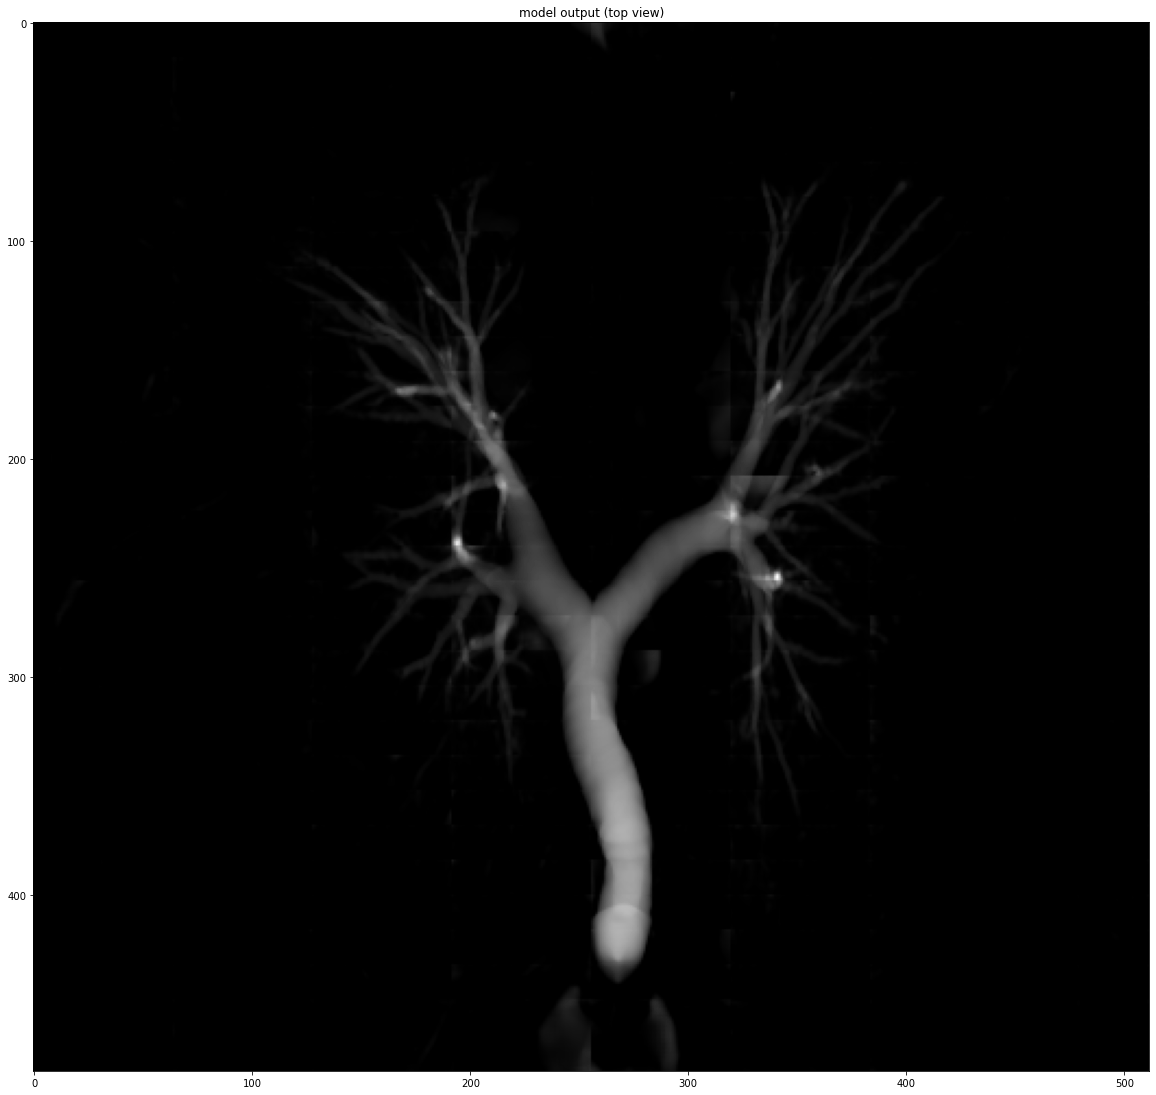

In [15]:
plt.figure(figsize=(20,20))
plt.title("model output (top view)")
plt.imshow(np.sum(seg_result_semi_supervise_learning, axis=1), cmap='gray')

2D visualization: chosen slice

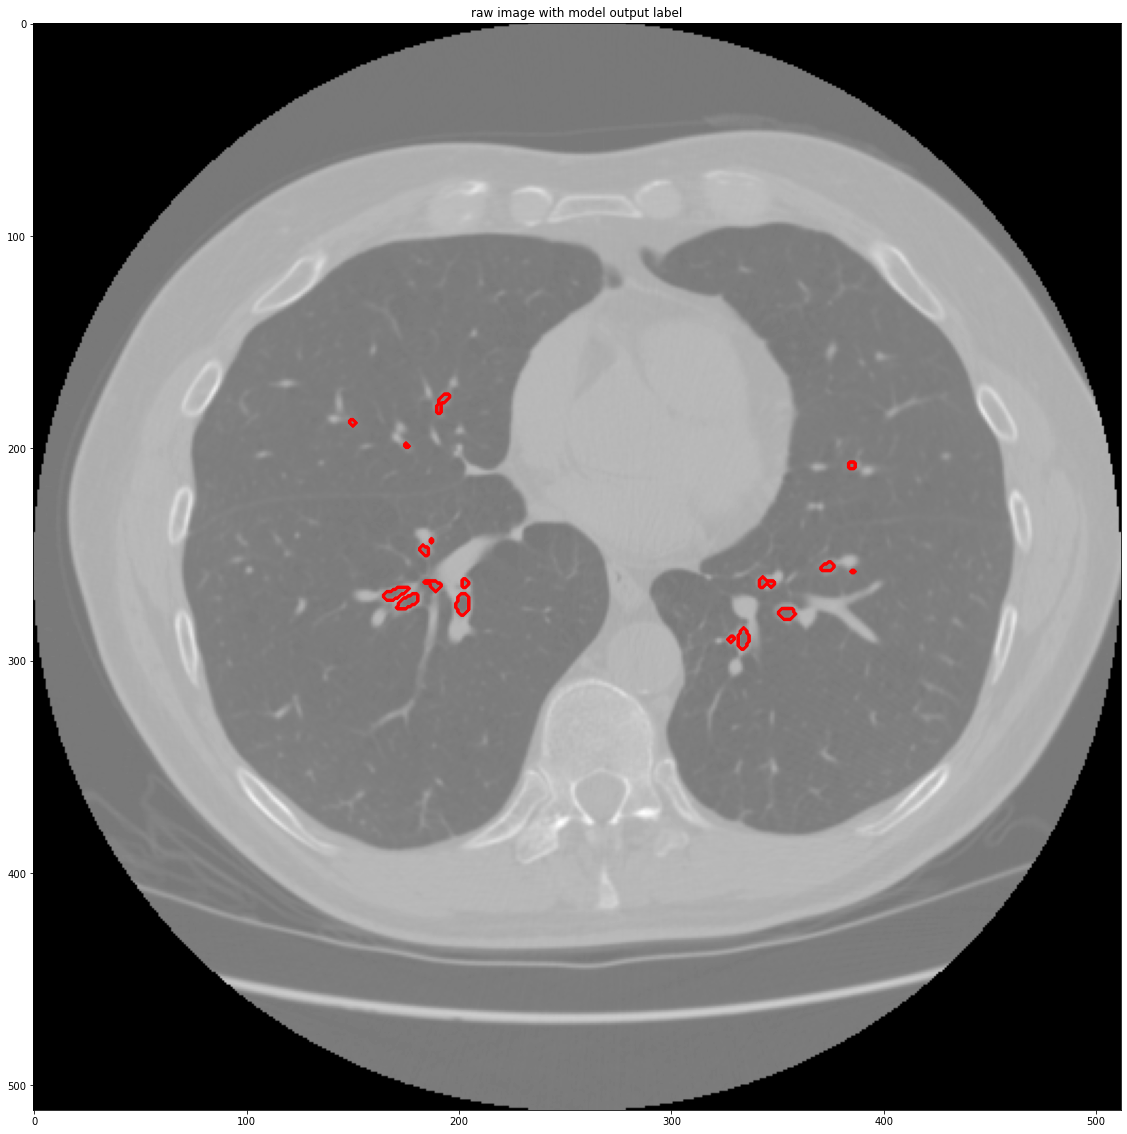

In [15]:
# choose the slice to show
# ----------
N=150
# ----------

plt.figure(figsize=(20,20))
plt.title("raw image with model output label")
plt.imshow(raw_img[N,:,:], cmap='gray')
plt.contour(seg_onehot_comb[N,:,:], colors='r', linestyles='-')

In [16]:
# ax = plt.figure().add_subplot(projection='3d')

# ax.voxels(seg_onehot_comb[96:128, 128:256, 128:256].transpose((1, 2, 0)))

# ax.set_xlim3d([0, 128])
# ax.set_ylim3d([0, 128])
# ax.set_zlim3d([0, 32])
# ax.set(xbound=[0, 128], ybound=[0, 128], zbound=[0, 128], )
# plt.show()

In [17]:
# ax = plt.figure().add_subplot(projection='3d')

# ax.voxels(seg_onehot_comb.transpose((1, 2, 0)))
# ax.set(xbound=[0, 512], ybound=[0, 512], zbound=[0, 512], )
# plt.show()

### post process I: find the max connected body

In [18]:
seg_processed,_ = post_process(seg_onehot_comb, threshold=threshold)

valid_neighbor_vals: [507 513 520 531 594 639 640 646 663 678 706 736 763 774 797 803 813 832
Assign label 969 to current val's neighbors: [507 513 520 531 594 639 640 646 663 678 706 736 763 774 797 803 813 832
valid_neighbor_vals: [438 451 456 462 474 523 535 553 588 593 601 627 633 681 741 776 802 833 789 795 814 910]903]900]
Assign label 969 to current val's neighbors: [438 451 456 462 474 523 535 553 588 593 601 627 633 681 741 776 802 833
valid_neighbor_vals: [395 439 443 470 526 537 542 570 597 598 600 632 649 693 784 790 807 837
Assign label 969 to current val's neighbors: [395 439 443 470 526 537 542 570 597 598 600 632 649 693 784 790 807 837
valid_neighbor_vals: [291 296 318 323 347 349 386 419 441 454 506 525 545 547 551 566 584 589 580 638 821]
Assign label 969 to current val's neighbors: [291 296 318 323 347 349 386 419 441 454 506 525 545 547 551 566 584 589
valid_neighbor_vals: [229 245 256 269 284 287 298 337 363 367 408 425 434 486 497 510 517 546
Assign label 969 to 

2D visualization: show top view

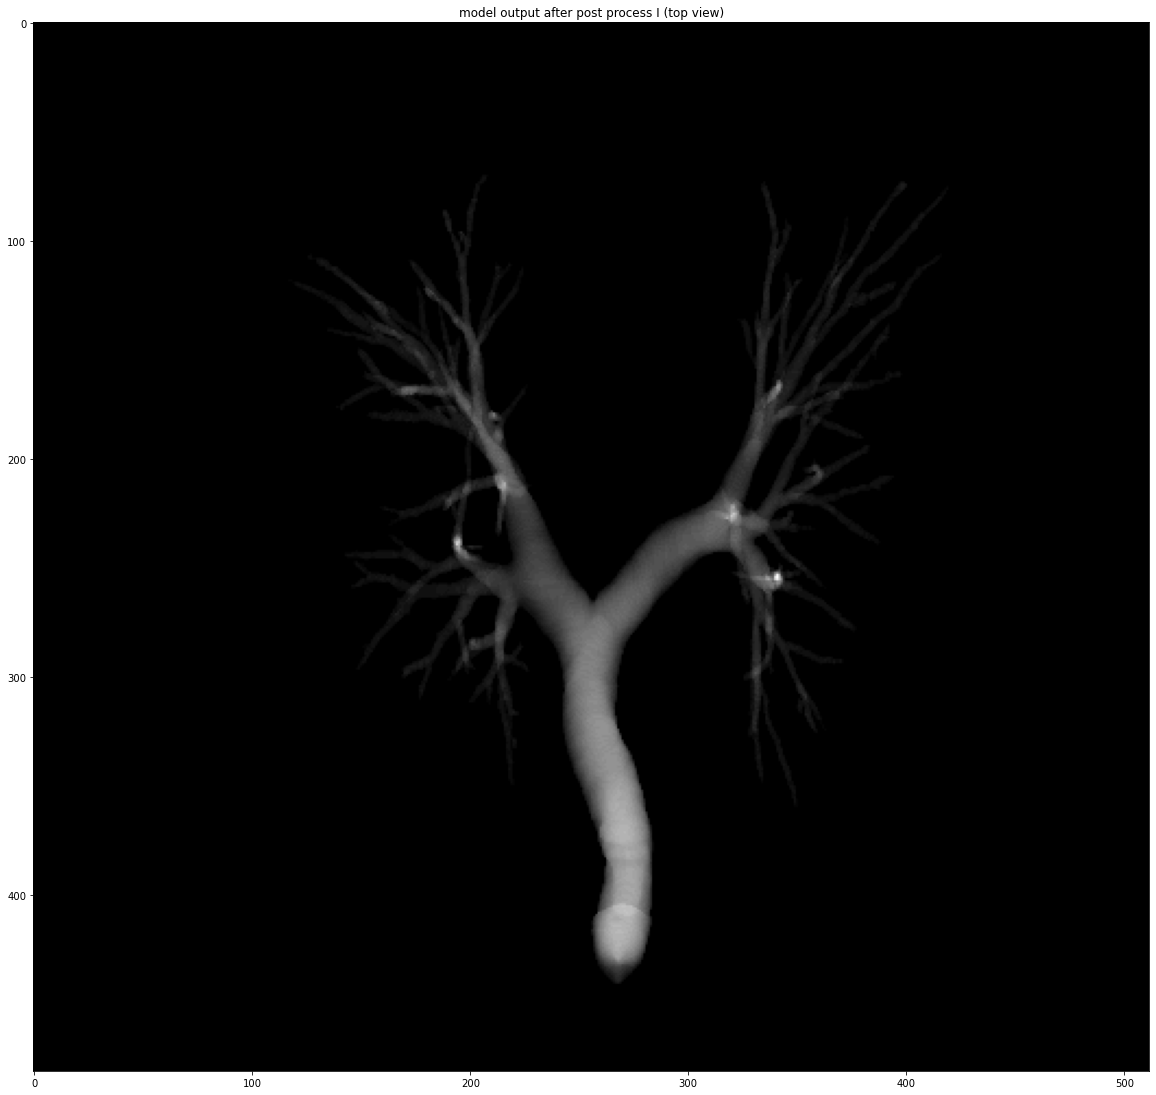

In [19]:
plt.figure(figsize=(20,20))
plt.title("model output after post process I (top view)")
plt.imshow(np.sum(seg_processed, axis=1), cmap='gray')

2D visualization: chosen slice

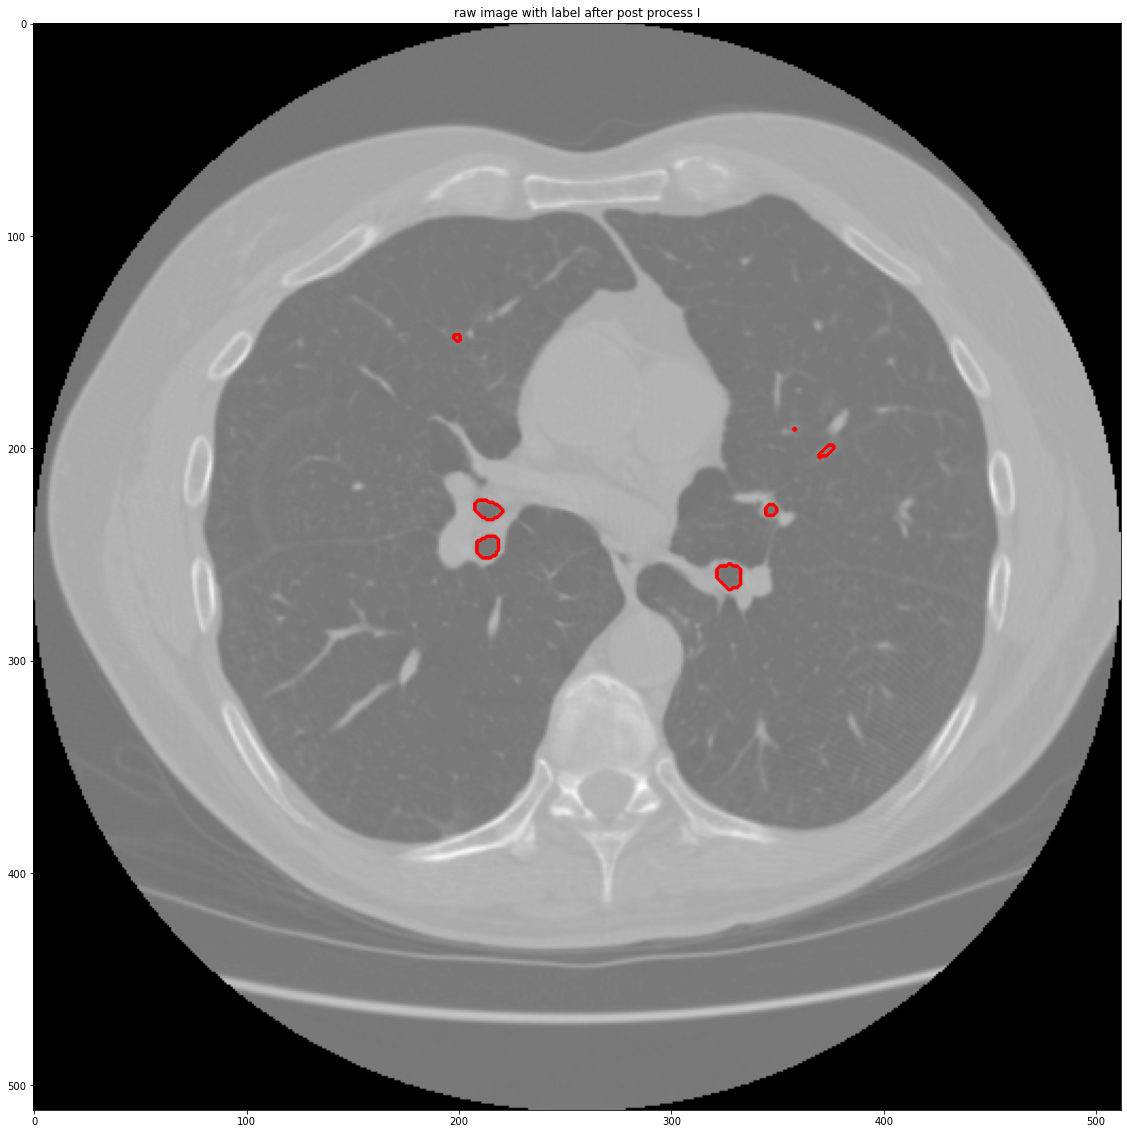

In [20]:
# choose the slice to show
# ----------
N=200
# ----------

plt.figure(figsize=(20,20))
plt.title("raw image with label after post process I")
plt.imshow(raw_img[N,:,:], cmap='gray')
plt.contour(seg_processed[N,:,:], colors='r', linestyles='-')

### airway centerline detection

In [21]:
seg_slice_label_I, connection_dict_of_seg_I, number_of_branch_I, tree_length_I = tree_detection(seg_processed, search_range=2)

c:\Users\sendo\Anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


3D visualization: show centerline

In [22]:
# # show the airway centerline
# def get_df_of_centerline(connection_dict):
#     d = {}
#     d["x"] = []
#     d["y"] = []
#     d["z"] = []
#     d["val"] = []
#     d["text"] = []
#     for item in connection_dict.keys():
#         print(item, end="\r")
#         d["x"].append(connection_dict[item]['loc'][0])
#         d["y"].append(connection_dict[item]['loc'][1])
#         d["z"].append(connection_dict[item]['loc'][2])
#         d["val"].append(connection_dict[item]['generation'])
#         d["text"].append(str(item)+": "+str({"before":connection_dict[item]["before"], "next":connection_dict[item]["next"]}))
#     df = pd.DataFrame(data=d)
#     return df

# # show the airway centerline
# def get_df_of_line_of_centerline(connection_dict):
#     d = {}
#     for label in connection_dict.keys():
#         if connection_dict[label]["before"][0]==0:
#             start_label = label
#             break
#     def get_next_point(connection_dict, current_label, d, idx):
#         while (idx in d.keys()):
#             idx+=1
        
#         d[idx]={}
#         if "x" not in d[idx].keys():
#             d[idx]["x"]=[]
#         if "y" not in d[idx].keys():
#             d[idx]["y"]=[]
#         if "z" not in d[idx].keys():
#             d[idx]["z"]=[]
#         if "val" not in d[idx].keys():
#             d[idx]["val"]=[]
        
#         before_label = connection_dict[current_label]["before"][0]
#         if before_label not in connection_dict.keys():
#             before_label = current_label
#         d[idx]["x"].append(connection_dict[before_label]["loc"][0])
#         d[idx]["y"].append(connection_dict[before_label]["loc"][1])
#         d[idx]["z"].append(connection_dict[before_label]["loc"][2])
#         d[idx]["val"].append(connection_dict[before_label]["generation"])
        
#         d[idx]["x"].append(connection_dict[current_label]["loc"][0])
#         d[idx]["y"].append(connection_dict[current_label]["loc"][1])
#         d[idx]["z"].append(connection_dict[current_label]["loc"][2])
#         d[idx]["val"].append(connection_dict[current_label]["generation"])
        
#         if connection_dict[current_label]["number_of_next"]==0:
#             return
#         else:
#             for next_label in connection_dict[current_label]["next"]:
#                 get_next_point(connection_dict, next_label, d, idx+1)
    
#     get_next_point(connection_dict, start_label, d,0)
#     return d

In [23]:
df_of_line_of_centerline = get_df_of_line_of_centerline(connection_dict_of_seg_I)

fig = go.Figure()

for item in df_of_line_of_centerline.keys():
    fig.add_trace(go.Scatter3d(x=df_of_line_of_centerline[item]["x"],
                               y=df_of_line_of_centerline[item]["y"],
                               z=df_of_line_of_centerline[item]["z"],mode='lines'))

fig.show('browser')

# fig.write_html("results/seg_result_centerline_proto.html")

### post process II: find the broken airway branches

In [24]:
seg_processed_II = add_broken_parts_to_the_result(connection_dict_of_seg_I, seg_result_comb, seg_processed, threshold = threshold,
                                                  search_range = 10, delta_threshold = 0.05, min_threshold = 0.4)

2D visualization: show top view

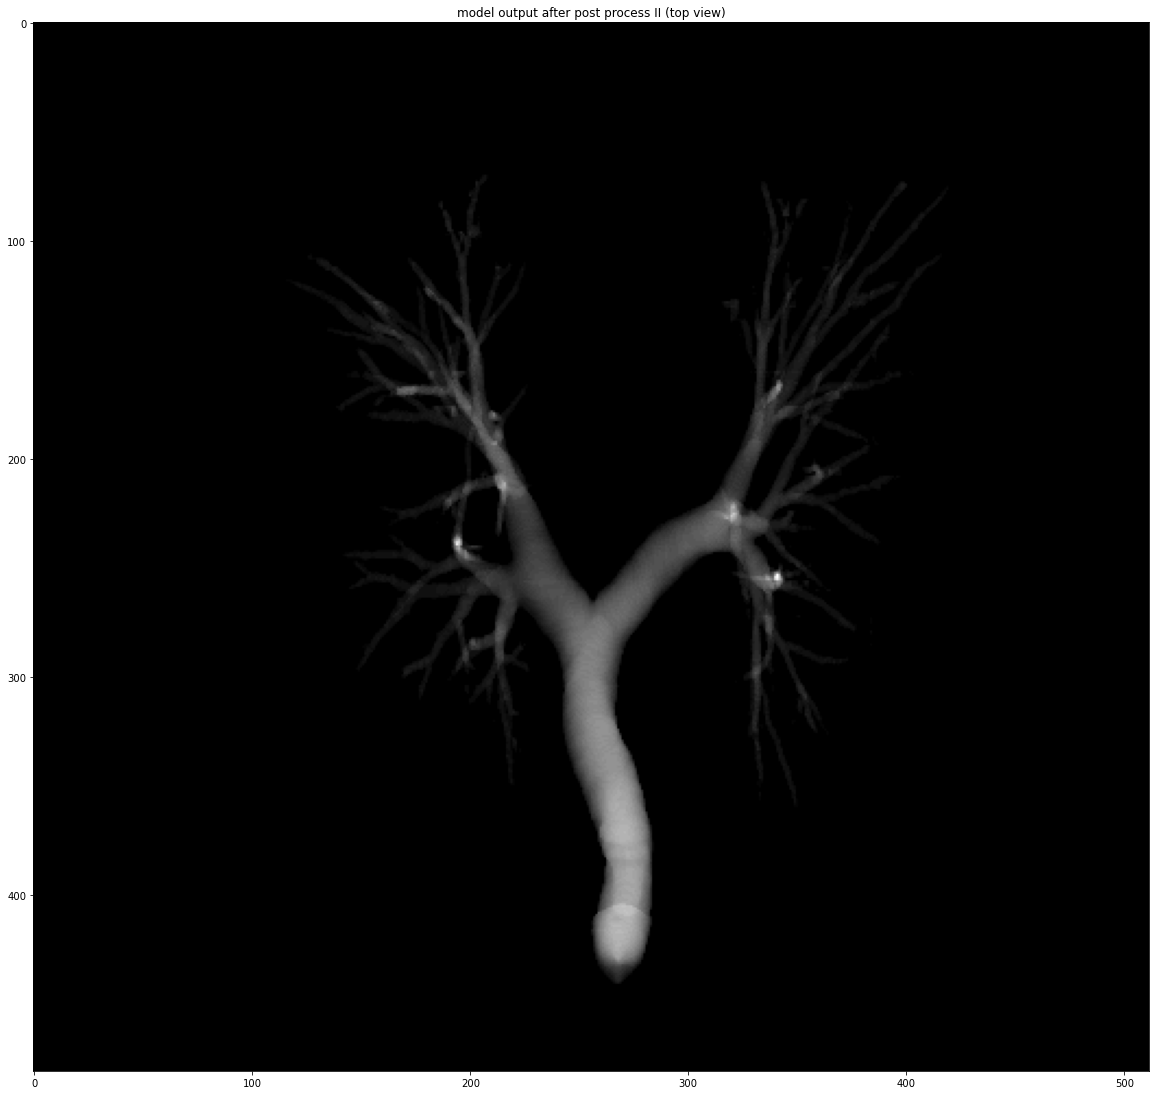

In [58]:
plt.figure(figsize=(20,20))
plt.title("model output after post process II (top view)")
plt.imshow(np.sum(seg_processed_II, axis=1), cmap='gray')

centerline re-detection

In [25]:
seg_slice_label_II, connection_dict_of_seg_II, number_of_branch_II, tree_length_II = tree_detection(seg_processed_II, search_range=2)

c:\Users\sendo\Anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning:

Downcasting int32 to uint8 without scaling because max value 1 fits in uint8



3D visualization: show centerline

In [28]:
df_of_line_of_centerline = get_df_of_line_of_centerline(connection_dict_of_seg_II)

fig = go.Figure()

for item in df_of_line_of_centerline.keys():
    fig.add_trace(go.Scatter3d(x=df_of_line_of_centerline[item]["x"],
                               y=df_of_line_of_centerline[item]["y"],
                               z=df_of_line_of_centerline[item]["z"],mode='lines'))

fig.show('browser')

# save the centerline result
fig.write_html("results/seg_result_centerline.html")

In [59]:
# generation >= 5 인 centerline에 대해, x값이 같은 평면에서 bfs
from collections import deque
def bfs(node, matrix):
    # do BFS on 2d matrix
    dr = [1, -1, 0, 0]
    dc = [0, 0, -1, 1]
    q = deque()
    q.append(node)

    if matrix[node[0]][node[1]] != 1:
        return
    
    matrix[node[0]][node[1]] == 2
    while len(q) > 0:
        r_cur, c_cur = q[-1]
        q.popleft()
        for i in range(4):
            r_next = r_cur + dr[i]
            c_next = c_cur + dc[i]
            if r_next < 0 or r_next >= matrix.shape[0] or c_next < 0 or c_next >= matrix.shape[1] or \
                matrix[r_next][c_next] != 1:
                continue
            matrix[r_next][c_next] = 2
            q.append([r_next, c_next])
            
seg_high_gen = seg_processed_II.copy()
for key, val in connection_dict_of_seg_II.items():
    if val['generation'] >= 5:
        bfs([val['loc'][1], val['loc'][2]], seg_high_gen[val['loc'][0]])

seg_high_gen = (seg_high_gen >= 2).astype(np.int32)

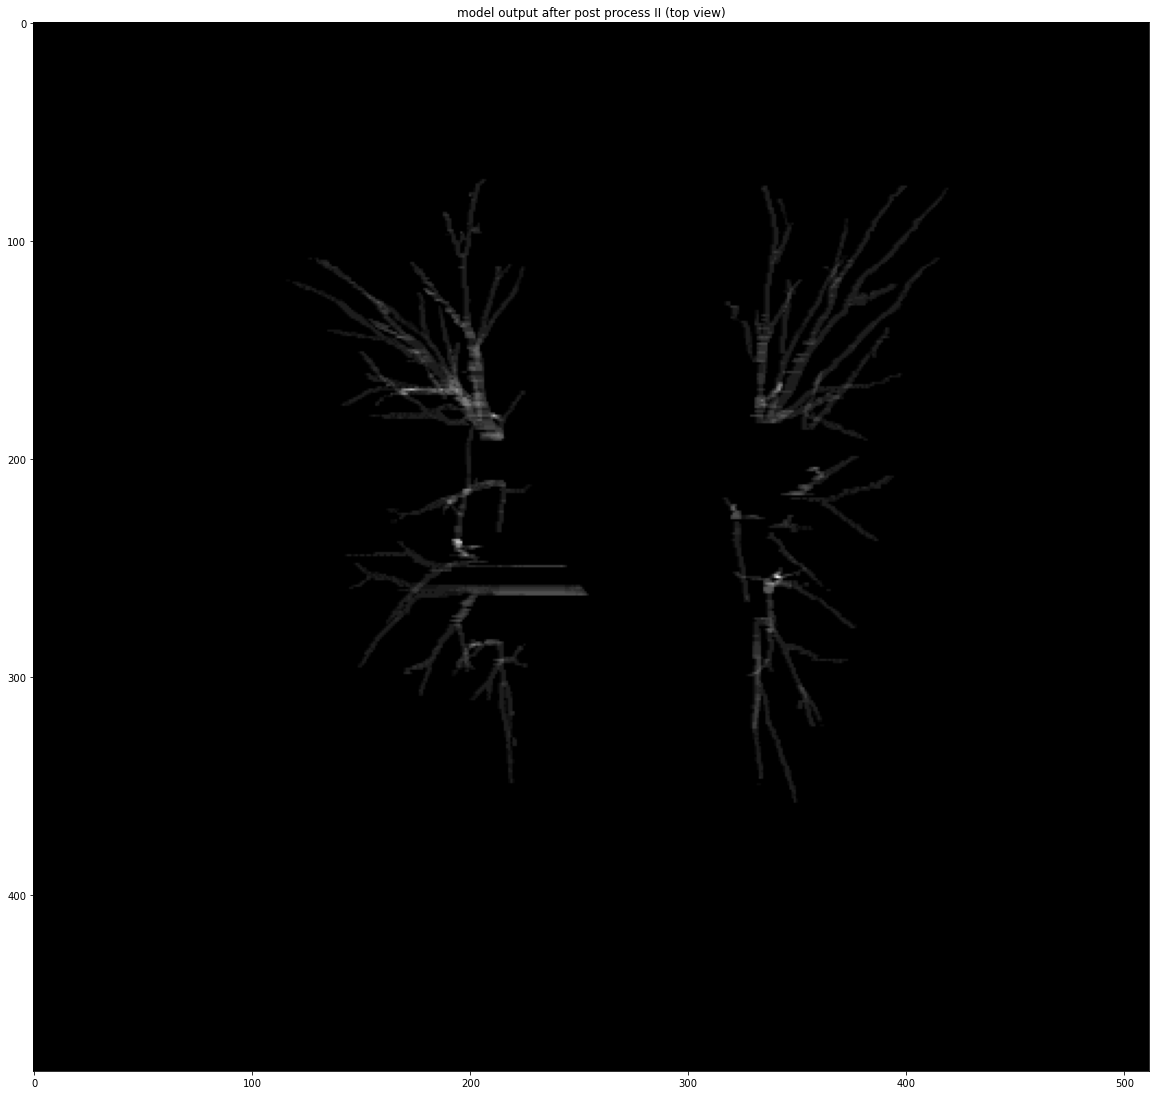

In [60]:
plt.figure(figsize=(20,20))
plt.title("model output after post process II (top view)")
plt.imshow(np.sum(seg_high_gen, axis=1), cmap='gray')

In [30]:
# ax = plt.figure().add_subplot(projection='3d')

# ax.voxels(seg_processed_II.transpose((1, 2, 0)))
# ax.set(xbound=[0, 512], ybound=[0, 512], zbound=[0, 512], )
# plt.show()

### save the results

In [62]:
output_file_path = "results"

In [63]:
sitk.WriteImage(sitk.GetImageFromArray(seg_high_gen),output_file_path+"/seg_high_gen.nii.gz")

In [32]:
sitk.WriteImage(sitk.GetImageFromArray(seg_processed),output_file_path+"/segmentation.nii.gz")
sitk.WriteImage(sitk.GetImageFromArray(seg_processed_II),output_file_path+"/segmentation_add_broken_parts.nii.gz")


### save the video

In [107]:
cmap_gray = plt.get_cmap('gray')

r_max = raw_img.max()
r_min = raw_img.min()

raw_img_rgb = []
for i in raw_img:
    raw_img_rgb.append((cmap_gray((i - r_min) / (r_max - r_min)) * (2**16 - 1)).astype(np.uint16)[:,:,:3])
    raw_img_rgb[-1] = cv2.cvtColor(raw_img_rgb[-1], cv2.COLOR_RGB2BGR)

In [108]:
cmap_viridis = plt.get_cmap('viridis')
heatmap = []
for i in seg_result:
    heatmap.append((cmap_viridis(i) * (2**16 - 1)).astype(np.uint16)[:,:,:3])
    heatmap[-1] = cv2.cvtColor(heatmap[-1], cv2.COLOR_RGB2BGR)

In [109]:
cmap2 = plt.get_cmap('Blues')
seg_onehot_comb_rgb = []
for i in seg_onehot_comb:
    seg_onehot_comb_rgb.append((cmap2(i.astype(float)) * (2**16 - 1)).astype(np.uint16)[:,:,:3])
    seg_onehot_comb_rgb[-1] = cv2.cvtColor(seg_onehot_comb_rgb[-1], cv2.COLOR_RGB2BGR)

In [110]:
seg_processed_II_rgb = []
for i in seg_processed_II:
    seg_processed_II_rgb.append((cmap2(i.astype(float)) * (2**16 - 1)).astype(np.uint16)[:,:,:3])
    seg_processed_II_rgb[-1] = cv2.cvtColor(seg_processed_II_rgb[-1], cv2.COLOR_RGB2BGR)

In [111]:
img_demo = cv2.hconcat((heatmap[250], seg_onehot_comb_rgb[250]))
cv2.imshow('img_demo', img_demo)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imwrite(output_file_path+'/img_demo.png', img_demo)

True

In [129]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_file_path+'/output.avi', fourcc, 30.0, (1024, 1024), True)
font=cv2.FONT_HERSHEY_SIMPLEX
for i in range(len(raw_img_rgb)):
    f11, f12, f21, f22 = raw_img_rgb[i], heatmap[i], seg_onehot_comb_rgb[i], seg_processed_II_rgb[i]
    f1 = cv2.hconcat((f11, f12))
    f2 = cv2.hconcat((f21, f22))
    frame = cv2.vconcat((f1, f2))
    # print(frame.shape)
    cv2.imshow('frame', frame)
    cv2.waitKey(1)
    out.write((frame / (2 ** 8)).astype(np.uint8))

out.release()
cv2.waitKey()
cv2.destroyAllWindows()

### save the results as 3d obj

In [ ]:
from func.points_to_mesh import produce_3d_obj

In [ ]:
produce_3d_obj(seg_processed, output_file_path+"/segmentation")

In [ ]:
produce_3d_obj(seg_processed_II, output_file_path+"/segmentation_add_broken_parts")